## Face Similarity using Xception Network with Triplet Loss

##### Import Libraries

In [0]:
import cv2
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.utils import Sequence
from keras.layers import Input, Dense, LeakyReLU, Concatenate, Lambda, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

final = pd.read_csv('identity_CelebA.txt',sep=" ",names = ['image_id','labels'])

## Plot random images

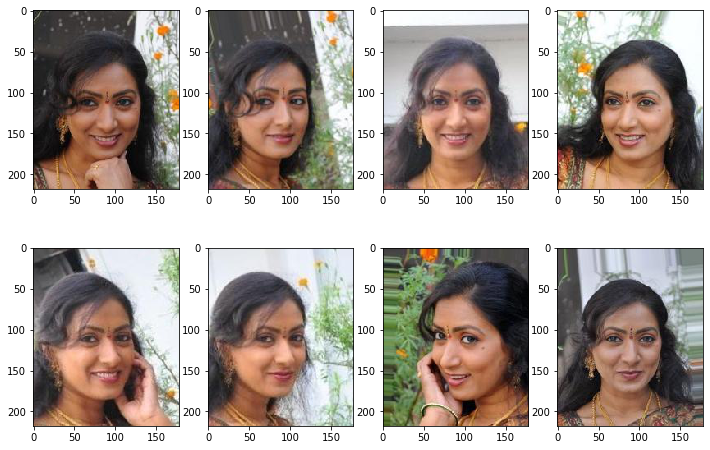

In [4]:
files = final.iloc[final['labels'].values == 11]['image_id'].values
rnd_files = np.random.choice(files, 8, replace=False)

plt.figure(figsize=(12,8))
for i, file in enumerate(rnd_files):
    plt.subplot(2,4,i+1)
    x = plt.imread('./data/celebA/{}'.format(file))
    plt.imshow(x)

## Crop Face of above plots using Haarcascade

In [0]:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [0]:
img_array = []
for img_file in rnd_files:
    try:
      img = cv2.imread('./data/celebA/{}'.format(img_file))
      label = int(final[final['image_id']==img_file.split('/')[-1]].to_dict(orient='record')[0]['labels'])   
      (x,y,w,h) = face_detector.detectMultiScale(img, 1.1, minNeighbors=8)[0]
      face = img[y:y+h, x:x+w]
      face = cv2.resize(face,(100,100))
      img_array.append(face.flatten())
    except Exception as err:
      print(err)
      print("Unable to detect the face using Haarcascade in file {}".format(img_file))

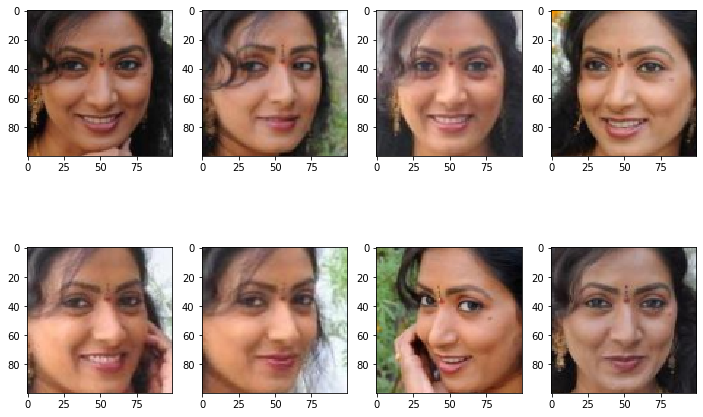

In [7]:
plt.figure(figsize=(12,8))
for i in range(len(img_array)):
    plt.subplot(2,4,i+1)
    k = img_array[i].reshape(100,100, 3)
    plt.imshow(k[:,:,::-1])

### We had taken subset of dataset i.e. 16869 images. It was difficult to train the model on whole dataset. 
So, We had processed the images and saved the data in final_emb.npy using generate_data.py file

In [0]:
final_data = np.load('final_emb.npy', allow_pickle=True)

In [0]:
final_data = pd.DataFrame(final_data.item())
final_data = final_data.sample(frac=1).reset_index(drop=True)

In [65]:
final_data.head()

,img_array,file_name,label
0,"[61, 58, 61, 57, 57, 61, 57, 56, 61, 50, 49, 5...",143832.jpg,40
1,"[78, 42, 34, 79, 43, 35, 80, 44, 36, 81, 45, 3...",157893.jpg,219
2,"[136, 195, 221, 134, 189, 216, 131, 184, 211, ...",057739.jpg,154
3,"[39, 77, 141, 44, 84, 143, 61, 99, 157, 69, 10...",153448.jpg,324
4,"[196, 178, 167, 187, 169, 162, 177, 162, 159, ...",040272.jpg,355


In [66]:
final_data.shape

(16869, 3)

Training data and Validation data

In [0]:
train = final_data[0:12000]
valid = final_data[12000:]

In [68]:
train

,img_array,file_name,label
0,"[61, 58, 61, 57, 57, 61, 57, 56, 61, 50, 49, 5...",143832.jpg,40
1,"[78, 42, 34, 79, 43, 35, 80, 44, 36, 81, 45, 3...",157893.jpg,219
2,"[136, 195, 221, 134, 189, 216, 131, 184, 211, ...",057739.jpg,154
3,"[39, 77, 141, 44, 84, 143, 61, 99, 157, 69, 10...",153448.jpg,324
4,"[196, 178, 167, 187, 169, 162, 177, 162, 159, ...",040272.jpg,355
...,...,...,...
11995,"[115, 143, 160, 124, 152, 169, 133, 161, 178, ...",163626.jpg,488
11996,"[34, 43, 56, 34, 43, 57, 43, 51, 69, 39, 48, 6...",093654.jpg,378
11997,"[3, 4, 8, 9, 10, 15, 14, 15, 20, 19, 19, 25, 2...",017588.jpg,76
11998,"[22, 29, 62, 1, 4, 24, 0, 0, 6, 7, 11, 13, 3, ...",060561.jpg,220


In [69]:
valid

,img_array,file_name,label
12000,"[16, 26, 43, 7, 16, 30, 4, 14, 24, 2, 11, 20, ...",074204.jpg,303
12001,"[150, 22, 3, 153, 26, 5, 156, 30, 4, 159, 32, ...",192902.jpg,570
12002,"[29, 67, 175, 20, 57, 167, 21, 57, 171, 20, 54...",106569.jpg,19
12003,"[0, 6, 19, 1, 19, 11, 0, 17, 0, 5, 16, 2, 17, ...",046354.jpg,219
12004,"[75, 81, 92, 78, 84, 96, 80, 86, 99, 80, 87, 1...",130211.jpg,354
...,...,...,...
16864,"[13, 28, 60, 21, 37, 66, 40, 53, 80, 42, 56, 7...",122694.jpg,282
16865,"[52, 73, 94, 48, 68, 86, 46, 65, 83, 52, 70, 8...",141223.jpg,10
16866,"[67, 76, 96, 50, 57, 76, 35, 40, 56, 19, 23, 3...",186931.jpg,574
16867,"[0, 1, 32, 5, 8, 39, 13, 16, 47, 4, 8, 37, 3, ...",118935.jpg,454


 ### Pretrained Xception Model (convolution features extractor)

In [0]:
xception = Xception(include_top=False, weights=None, input_shape = (100, 100, 3))
output = GlobalAveragePooling2D()(xception.output)
base_model = Model(xception.input, output)

# It encodes the image into 128 dims.
def embedder(conv_feat_size):
    input = Input((conv_feat_size,), name = 'input')
    normalize = Lambda(lambda x: K.l2_normalize(x, axis=-1), name='normalize')
    x = Dense(512)(input)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(128)(x)
    x = normalize(x)
    model = Model(input, x)
    return model
    
def get_model(base_model):
    
    inp_shape = K.int_shape(base_model.input)[1:]
    conv_feat_size = K.int_shape(base_model.output)[-1]
    
    input_a = Input( inp_shape,  name='anchor')
    input_p = Input( inp_shape,  name='positive')
    input_n = Input( inp_shape,  name='negative')
    emb_model = embedder(conv_feat_size)
    output_a = emb_model(base_model(input_a))
    output_p = emb_model(base_model(input_p))
    output_n = emb_model(base_model(input_n))
    
    merged_vector = Concatenate(axis=-1)([output_a, output_p, output_n])
    model = Model(inputs=[input_a, input_p, input_n],
                  outputs=merged_vector)

    return model

model = get_model(base_model)


## Triplet Loss

loss = cosine(anchor, positive) + cosine(anchor, negative) + alpha

In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    embedding_size = K.int_shape(y_pred)[-1] // 3
    ind = int(embedding_size * 2)
    a_pred = y_pred[:, :embedding_size]
    p_pred = y_pred[:, embedding_size:ind]
    n_pred = y_pred[:, ind:]
    positive_distance = 1 - K.sum((a_pred * p_pred), axis=-1)
    negative_distance = 1 - K.sum((a_pred * n_pred), axis=-1)
    loss = K.maximum(0.0, positive_distance - negative_distance + alpha)
    return loss


In [0]:
class face_data_generator(Sequence):
    def __init__(self, df, preprocess_function, batchSize = 16, flip=False):
        self.files = df['file_name'].values
        self.batchSize = batchSize
        self.y = df['label'].values
        self.data_f = df
        self.N = len(self.y)
        self.shape = (100, 100)
        self.function = preprocess_function
        
    def load_image_arr(self, file):
        img = self.data_f[self.data_f['file_name'] == file].to_dict(orient='record')[0]['img_array'].reshape(100,100,3)
        img = self.function(img)
        return img

    def __len__(self):
        l,rem = divmod(self.N, self.batchSize)
        return (l + (1 if rem > 0 else 0))
    
    def on_epoch_end(self):
        a = np.arange(len(self.y))
        np.random.shuffle(a)
        self.files = self.files[a]
        self.y = self.y[a]
        
    #gets a batch with index = i
    def __getitem__(self, i):
        start = i*self.batchSize
        stop  = np.min([(i+1)*self.batchSize, self.N]) 
        ANCHOR = np.zeros( (stop-start,) + self.shape + (3,) )
        POSITIVE = np.zeros( (stop-start,) + self.shape + (3,) )
        NEGATIVE = np.zeros( (stop-start,) + self.shape + (3,) )
        ancor_labels = self.y[start:stop]
        ancor_images = self.files[start:stop]
        pos_images = []
        neg_images = []
        for k, label in enumerate(ancor_labels):
            pos_idx = np.where(self.y==label)[0]
            neg_idx = np.where(self.y!=label)[0]
            neg_images.append(self.files[np.random.choice(neg_idx)])
            pos_idx_hat = pos_idx[(pos_idx<start) | (pos_idx>stop)]
            if len(pos_idx_hat):
                pos_images.append(self.files[np.random.choice(pos_idx_hat)])
            else:
                # positive examples are within the batch or just 1 example in dataset
                pos_images.append(self.files[np.random.choice(pos_idx)])
                
        for k, (a, p, n) in enumerate(zip(ancor_images, pos_images, neg_images)):
            ANCHOR[k] = self.load_image_arr(a)
            POSITIVE[k] = self.load_image_arr(p)
            NEGATIVE[k] = self.load_image_arr(n)
            
        return [ANCHOR, POSITIVE, NEGATIVE], np.empty(k+1)

## Training Model

In [73]:
train_gen = face_data_generator(train, preprocess_input, batchSize = 32)
valid_gen = face_data_generator(valid, preprocess_input, batchSize = 32)
model.compile(Adam(lr = 0.0001), loss = triplet_loss)

checkpoint = ModelCheckpoint('har_xception.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

model.fit_generator(train_gen, steps_per_epoch=len(train_gen), 
                    epochs=4, validation_data=valid_gen, 
                    validation_steps=len(valid_gen), callbacks=[checkpoint])

model.load_weights('har_xception.h5')

# save the  model
model.save('har_xception.h5')

Epoch 1/4
375/375 [==============================] - 424s 1s/step - loss: 0.1158 - val_loss: 0.1032

Epoch 00001: val_loss improved from inf to 0.10322, saving model to har_xception.h5
Epoch 2/4
375/375 [==============================] - 379s 1s/step - loss: 0.0858 - val_loss: 0.0948

Epoch 00002: val_loss improved from 0.10322 to 0.09483, saving model to har_xception.h5
Epoch 3/4
375/375 [==============================] - 379s 1s/step - loss: 0.0695 - val_loss: 0.0938

Epoch 00003: val_loss improved from 0.09483 to 0.09384, saving model to har_xception.h5
Epoch 4/4
375/375 [==============================] - 378s 1s/step - loss: 0.0632 - val_loss: 0.0845

Epoch 00004: val_loss improved from 0.09384 to 0.08446, saving model to har_xception.h5


## Testing Model

In [0]:
from keras.models import load_model

model = load_model('har_xception.h5', custom_objects={'triplet_loss': triplet_loss})

inp = model.layers[0].input
base_model = model.layers[3]
emb_model = model.layers[4]
model = Model(inp, emb_model(base_model(inp)))

In [0]:
def show(file):
    plt.figure()
    x = plt.imread('./data/celebA/{}'.format(file))
    plt.imshow(x)

In [0]:
def load_img(file):
    img = cv2.imread('./data/celebA' + '/{}'.format(file), -1)
    (x,y,w,h) = face_detector.detectMultiScale(img, 1.01, minNeighbors=8)[0]
    img = img[y:y+h, x:x+w]
    img = cv2.resize(img,(100,100))  
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [0]:
def similarity(file1, file2, im1,im2):
    show(file1)
    show(file2)
    pred1 = model.predict(im1)
    pred2 = model.predict(im2)
    return cosine_similarity(pred1, pred2)


In [0]:
def compare(im1_path, im2_path):
    im1 = load_img(im1_path)
    im2 = load_img(im2_path)
    print("Similarity Score is {}".format(similarity(im1_path, im2_path, im1, im2)))


### Selecting 2 random samples for testing

In [0]:
test_files = final_data['file_name'].values
te_ind = np.random.choice(files, 2, replace=False)

### Computing the Similarity Score

Similarity Score is [[0.90119326]]


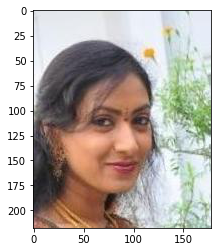

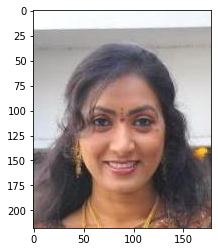

In [132]:
compare(te_ind[0], te_ind[1])